### Initialization

In [ ]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [ ]:
import network_flow_tracker.linking as NFTLinking
import network_flow_tracker.FlowGraph as FG
import network_flow_tracker.analysis as NFTAnalysis
import network_flow_tracker.visualization as NFTVis
import network_flow_tracker.LFBFP as LFBFP
import network_flow_tracker.utils.io as io
import network_flow_tracker.utils.vis as vis
import network_flow_tracker.utils.neighbors as nb
import network_flow_tracker.utils.stat as stat
import network_flow_tracker.utils.util as util
import network_flow_tracker.utils.graph as graph

In [ ]:
data_group = 'Lightfield'
dataset = 'Zhang2020'
data_root_path = f'C:\\Data\\{data_group}\\{dataset}'
process_data_root = os.path.join(data_root_path, 'processed_data')
vis_folder_root = os.path.join(data_root_path, 'visualization')

In [ ]:
info_fp = os.path.join(process_data_root, 'data_info.pickle')
data_info = io.load_data(info_fp)
voxel_size_um = data_info['target_voxel_size_um']
frame_rate_Hz = data_info['frame_rate_Hz']
mm2s_to_pxl2s = 1e3 / frame_rate_Hz / voxel_size_um
avg_hematocrit = 0.5
cell_labeled_fraction = 0.1
lfp = LFBFP.LFBFProcessing(data_root_path, data_info)

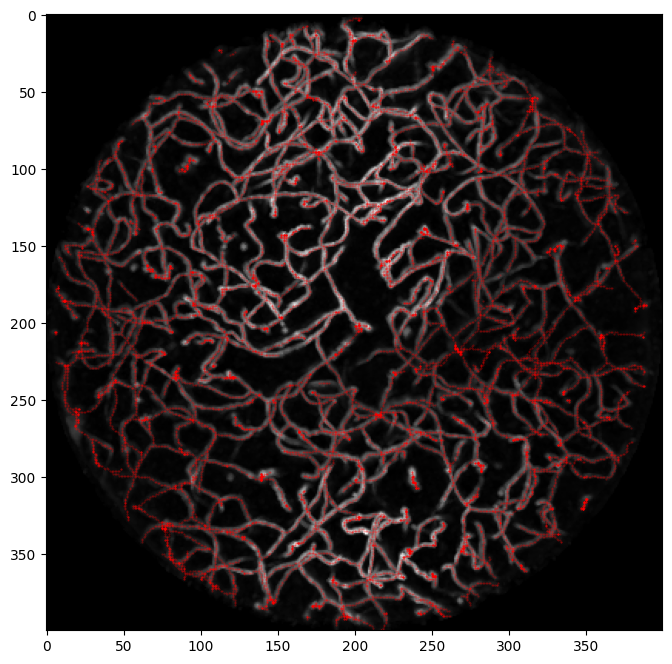

In [9]:
debug_Q = True
save_fig_Q = False
rm_node_voxel_on_vol_boundary_Q = True
z_idx = 1
z_folder_name = data_info['raw_data_folders'][z_idx]
vis_folder = os.path.join(vis_folder_root, 'analysis_20251201', z_folder_name)
vis_fp_prefix = f"{data_group}_{dataset}_{z_folder_name}"
data_folder = os.path.join(process_data_root, 'tracking')
data_fp = sorted(glob.glob(os.path.join(data_folder, f"{z_folder_name}_tk_w_pdt*")))
if len(data_fp) > 1: 
    data_fp = data_fp[-1]
else: 
    data_fp = data_fp[0]

tk_data = io.load_data(data_fp)
sv_data = tk_data['sv_data']
sv_disp_vec = sv_data['disp_vec']
mask_size = sv_data['mask_size']
vsl_im_vol = sv_data['im']
vsl_mips = vis.compute_three_view_mip(sv_data['im'])
vsl_mask = sv_data['label_array'] > 0

if 'graph_version' in tk_data:
    stitch_data_fp = tk_data['graph_version']
    stitch_data_fn = os.path.split(stitch_data_fp)[-1]
    stitch_data_fp = os.path.join(process_data_root, 'itk', 'recon', 
                                  stitch_data_fn)
else: 
    raise ValueError("Unknown global graph version")
stitch_data = LFBFP.LFBFProcessing.load_and_parse_annotation_data(stitch_data_fp)
whole_mask_size = stitch_data['mask_size']

# visual check 
if debug_Q:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    # This vascular image has been high-pass-filtered. Large vessel might have black reigon inside. 
    ax.imshow(vsl_mips['yx'], cmap='gray')
    ax.scatter(sv_data['skl_sub'][2], sv_data['skl_sub'][1], 0.25, color='r', alpha=0.3)

In [10]:
lk_hdl = NFTLinking.Linking(tk_data['tracking_all'], mask_size)
all_pid_to_idx = util.get_table_value_to_idx_dict(tk_data['tracking_all'], key='pid')
all_el_to_idx = util.get_table_value_to_idx_dict(tk_data['tracking_all'], key='edge_label', filter=lambda x: x>=0)

skl_r_array = np.zeros(sv_data['mask_size'], np.float16)
skl_r_array.flat[sv_data['skl_ind']] = sv_data['skl_r_v']
skl_label_array = np.zeros(sv_data['mask_size'], dtype=np.int8)
skl_label_array.flat[sv_data['skl_ind']] = sv_data['skl_label_v']
fg = FG.FlowGraph(skl_label_array > 0)
fg.init_nearest_skl_map(vsl_skl_labeled=skl_label_array, vsl_vol_labeled=sv_data['label_array'])
fg.init_velocity(tk_data['edge_v_pxl'], tk_data['edge_v_std_pxl'], tk_data['edge_track_frac'])

11 skeleton voxels are labeled as vein in vsl_skl_labeled, but as capillary in vsl_vol_labeled. Correct to capillary.


In [11]:
ptrace_result = tk_data['tracking_ns']
# Update the edge label - just in case the edge label changes in the reconstructed graph
# Map the detection position to the nearest skeleton voxel position. 
ptrace_result['skl_ind'] = fg.nearest_map.ind_to_nearest_ind(ptrace_result.ind.values)
ptrace_result['edge_label'] = fg.edge.ind_to_label(ptrace_result['skl_ind'].values)
ptrace_result['node_label'] = fg.node.ind_to_label(ptrace_result['skl_ind'].values)
# If the skeleton does not change, there's no need to update the exit_ind.

In [12]:
# accept long traces directly. For short traces, select
particle_key = 'particle'
min_len = 2
min_len_direct_accept = 4
max_accept_cost = 5
max_accept_cost_n = 0.5
long_traces_ind = LFBFP.Linking.select_long_trajectories_from_trackpy_result(ptrace_result, min_len, sortedQ=-1, particle_key=particle_key)
p_cost_n = np.abs(ptrace_result.cost.values / fg.edge_v_pxl[ptrace_result.edge_label.values])

valid_traces_ind = []
for i, idx in enumerate(long_traces_ind):
    if idx.size >= min_len_direct_accept:

        valid_traces_ind.append(idx)
    else: 
        tmp_nb = ptrace_result.num_cands.values[idx[:-1]]
        tmp_c = ptrace_result.cost.values[idx[:-1]]
        tmp_c_n = p_cost_n[idx[:-1]]
        if np.all(tmp_c < max_accept_cost) or np.all(tmp_c_n < max_accept_cost_n) or np.all(tmp_nb == 1): 
            valid_traces_ind.append(idx)

valid_traces_ind = np.asarray(valid_traces_ind, object)

para_teve = {'gm_max_num_est': 3,  # maximum number of mixture-of-gaussian fitting (random initialization) 
             'min_data_size': 5,  # minimal data size for fitting
             'min_gmc_dist_std_n': 2} # minimal mixture-of-gaussian normalized mean difference. If 2 components fit the distribution better but their spacing is smaller than this value, re-do the fitting
para_teves = {'min_weight_ratio': 1.5, 
              'min_track_fraction': 0.3, 
              'max_abs_cv': 0.8, 
              'max_std_to_ignore_cv': 2}

edge_tk_v_results = NFTLinking.analyze_edge_velocity_from_tracking(fg, ptrace_result, valid_traces_ind, particle_key=particle_key, **para_teve)
edge_trkb_v, edge_trkb_v_std = NFTLinking.select_edge_velocity_from_tracking_analysis(edge_tk_v_results, **para_teves)

C:\Users\xj0996\AppData\Local\Temp\ipykernel_106356\4197661296.py:8: RuntimeWarning: divide by zero encountered in divide
  p_cost_n = np.abs(ptrace_result.cost.values / fg.edge_v_pxl[ptrace_result.edge_label.values])


Finish constructing voxel speed map using (28061 of 28065) traces. 
Finish constructing skeleton speed map.
Finish analyzing flow velocity in edge 880. 
Finish analyzing edge velocity from the tracking result


In [13]:
e_missing_v_Q = np.isnan(fg.edge_v_pxl)
fg.edge_v_pxl[e_missing_v_Q] = edge_trkb_v[e_missing_v_Q]
fg.edge_v_std_pxl[e_missing_v_Q] = edge_trkb_v_std[e_missing_v_Q]

In [14]:
num_skl_vxl, num_t_pts = fg.vxl_speed_map.shape
p_pid_to_idx = util.get_table_value_to_idx_dict(ptrace_result, key='particle')
p_el_to_idx = util.get_table_value_to_idx_dict(ptrace_result, key='edge_label', filter=lambda x: x>=0)

## Overall statistics

### Compute features

In [15]:
# Get edge vessel type
whole_graph = graph.SpatialGraph(stitch_data['skl_ind'], stitch_data['mask_size'])
map_ind_to_type = nb.construct_array_sparse_representation(stitch_data['skl_ind'], [np.prod(stitch_data['mask_size']), 1], 
                                                           stitch_data['skl_label'].flatten().astype(np.int8))
wg_efs = {}
wg_efs['type'] = whole_graph.edge.get_cc_feature_from_voxel_array(map_ind_to_type, stat=['mode'])['mode']
wg_nfs = {}
wg_nfs['type'] = whole_graph.node.get_cc_feature_from_voxel_array(map_ind_to_type, stat=['mode'])['mode']
# The vessel radius estimation is not very reliable here. Use the vessel type only for branch order calculation 
source_type = 2
end_type = 3
vsl_type = wg_efs['type'].astype(np.int8)
artery_label = np.nonzero(vsl_type == source_type)[0]
vein_label = np.nonzero(vsl_type == end_type)[0]
wg_efs['BOA'] = whole_graph.compute_edge_branch_order(source_label=artery_label, drain_label=vein_label)
wg_efs['BOV'] = whole_graph.compute_edge_branch_order(source_label=vein_label, drain_label=artery_label)

# should do the same thing for the nodes 
artery_label = np.nonzero(wg_nfs['type'] == source_type)[0]
vein_label = np.nonzero(wg_nfs['type'] == end_type)[0]
wg_nfs['BOA'] = whole_graph.compute_node_branch_order(source_label=artery_label, drain_label=vein_label)
wg_nfs['BOV'] = whole_graph.compute_node_branch_order(source_label=vein_label, drain_label=artery_label)

In [ ]:
mv_avg_wd_t = 0.5
mv_avg_wd = int(mv_avg_wd_t * data_info['frame_rate_Hz'])
mv_min_num = 3
# Compute traces for all the edges
edges_traces = NFTAnalysis.compute_edges_spatiotemporal_traces(fg, ptrace_result, p_el_to_idx, mv_avg_wd, mv_min_num, 
                                                               voxel_size_um, data_info['frame_rate_Hz'], cell_labeled_fraction)

In [ ]:
p_t_v_stat = {k: np.full(fg.edge.num_cc, np.nan) for k in ['med', 'num_data', 'eff_cv', 'sm_eff_cv', 'v_rev_ratio']}
for i, tmp_et_data in edges_traces.items():
    p_t_v_stat['v_rev_ratio'][i] = tmp_et_data['stat_p_v']['reverse_frac']
    p_t_v_stat['med'][i] = tmp_et_data['stat_p_v']['median'] 

    tmp_stat = stat.compute_basic_statistics(tmp_et_data['p_t_v_mean'])
    p_t_v_stat['eff_cv'][i] = tmp_stat['eff_ptrl_cv']
    tmp_stat_sm =  stat.compute_basic_statistics(tmp_et_data['e_t_v_mean_sm'])
    p_t_v_stat['sm_eff_cv'][i] = tmp_stat_sm['eff_ptrl_cv']
    
    p_t_v_stat['num_data'][i] = tmp_et_data['stat_p_v']['num_data']

/home/xij072/Documents/Github/Network_flow/utils/stat.py:39: RuntimeWarning: invalid value encountered in sqrt
  stat['std'] = np.sqrt(mean_x2 - stat['mean'] ** 2)
/home/xij072/Documents/Github/Network_flow/utils/stat.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  stat['eff_ptrl_cv'] = np.abs(stat['eff_ptrl_std'] / stat['median'])


In [ ]:
edge_features = fg.edge.compute_geometric_features(fg.edge.cc_ind, mask_size, ep_vec_nb=8, voxel_size_um=voxel_size_um)
# add to edge features
for k, v in wg_efs.items():
    edge_features[k] = LFBFP.get_subgraph_cc_feature_from_whole_graph_cc_feature(whole_graph, v, fg, sv_disp_vec, obj='edge')

/home/xij072/Documents/Github/Network_flow/utils/neighbors.py:111: UserWarning: voxel_val has elements being 0.
  warnings.warn("voxel_val has elements being 0.")


In [ ]:
edge_features['v'] = np.abs(p_t_v_stat['med'])
edge_features['v_cv'] = p_t_v_stat['eff_cv']
edge_features['v_sm_cv'] = p_t_v_stat['sm_eff_cv']
edge_features['l2v'] = np.abs(edge_features['length'] / (edge_features['v'] * frame_rate_Hz))
edge_features['p_v_rev_frac'] = p_t_v_stat['v_rev_ratio']
edge_features['num_p'] = p_t_v_stat['num_data']
edge_features['has_exit_ep_Q'] = np.logical_and((fg.edge.num_connected_node == 1), (edge_features['v'] > 0))


/tmp/ipykernel_2967237/3892764235.py:4: RuntimeWarning: divide by zero encountered in divide
  edge_features['l2v'] = np.abs(edge_features['length'] / (edge_features['v'] * frame_rate_Hz))


In [ ]:
# Node features
node_features = {}
for k, v in wg_nfs.items():
    node_features[k] = LFBFP.get_subgraph_cc_feature_from_whole_graph_cc_feature(whole_graph, v, fg, sv_disp_vec, obj='node')

nfc_info = fg.compute_node_flow_configuration(known_edge_v=fg.edge_v_pxl)

for k in ['num_in', 'num_out', 'num_unknown']: 
    node_features[k] = nfc_info[f'n_{k}'].astype(np.int8)
node_features['is_1_in_Q'] = np.logical_and(np.logical_and(node_features['num_in'] == 1, node_features['num_unknown'] == 0), node_features['num_out'] > 1)
node_features['is_1_out_Q'] = np.logical_and(np.logical_and(node_features['num_out'] == 1, node_features['num_unknown'] == 0), node_features['num_in'] > 1)

In [ ]:
nl_1_in_2_out_nl = np.nonzero(np.logical_and(node_features['is_1_in_Q'], node_features['num_out'] == 2))[0]
print(f"Number of 1-in-2-out nodes: {nl_1_in_2_out_nl.size}")

n_fbf_data = {}
for i, tmp_nl in enumerate(nl_1_in_2_out_nl): 
    try: 
        tmp_n_fbf = NFTAnalysis.analyze_node_flow_config_1_in_2_out(tmp_nl, fg, edge_features, edges_traces, ptrace_result, p_pid_to_idx, p_el_to_idx, mv_avg_wd, num_t_pts)    
        if tmp_n_fbf['p_num_cell']: 
            tmp_n_fbf['BOA'] = node_features['BOA'][tmp_nl]
            n_fbf_data[tmp_nl] = tmp_n_fbf
        else: 
            print(f"Node {tmp_nl} does not have any selected detected cells in the parent edge")
    except Exception as e: 
        print(f"{e}")
n_fbf_data = util.dict_of_dict_to_dict_of_array(n_fbf_data, to_numpy_Q=True)

Number of 1-in-2-out nodes: 170
Node 453 does not have any selected detected cells in the parent edge
Node 455 does not have any selected detected cells in the parent edge
Node 457 does not have any selected detected cells in the parent edge


/home/xij072/Documents/Github/Network_flow/utils/stat.py:39: RuntimeWarning: invalid value encountered in sqrt
  stat['std'] = np.sqrt(mean_x2 - stat['mean'] ** 2)


In [ ]:
# 1-in-2-out Node partition 
min_data = 25
tmp_valid_Q = n_fbf_data['p_num_cell'] >= min_data
tmp_valid_Q = np.logical_and(tmp_valid_Q, np.logical_and(n_fbf_data['BOA'] >= 1, n_fbf_data['BOA'] <= 8))
tmp_valid_Q = np.logical_and(tmp_valid_Q, np.all(np.isfinite(n_fbf_data['c_ps_p_m']), axis=1))
tmp_valid_Q = np.logical_and(tmp_valid_Q, np.all(np.isfinite(n_fbf_data['c_avg_vf_r']), axis=1))
vis_fbf_data = util.mask_data_in_dict(n_fbf_data, tmp_valid_Q)

vis_fb_vs_BOA_t = pd.DataFrame({'node_label': vis_fbf_data['key'],
                          'BOA': vis_fbf_data['BOA'].astype(np.uint16), 
                          'p_c1': np.max(vis_fbf_data['c_ps_p_m'], axis=1), 
                          'v_bias_ratio': 2 * (np.max(vis_fbf_data['c_avg_v_r'], axis=1) - 0.5), 
                          'v_raw_bias_ratio': 2 * (np.max(vis_fbf_data['c_avg_v_r_raw'], axis=1) - 0.5), 
                          'vf_bias_ratio':  2* (np.max(vis_fbf_data['c_avg_vf_r'], axis=1) - 0.5)})

ps_mv_avg_wd = 70
bf_node_list = vis_fb_vs_BOA_t.node_label.values
ps_ns_stat = {k: np.zeros(bf_node_list.size) for k in ['max', 'sum', 'p_obs_f']}
ps_ns_stat['node_label'] = bf_node_list
z_th = 1.96
min_p_mv_count = 10

for i, vis_node in enumerate(list(bf_node_list)): 
    tmp_n_fw_info, ds_e_count = NFTAnalysis.compute_edge_downstream_cell_partition_trace_by_passenger(fg, vis_node, ps_mv_avg_wd, num_t_pts, mv_wd_min_n=3)
    tmp_ds_data = ds_e_count[tmp_n_fw_info['c_el'][0]]
    p_avg = tmp_ds_data['avg_p']
    tmp_z_mask = np.logical_or(tmp_ds_data['p_ci_l'] > p_avg, tmp_ds_data['p_ci_h'] < p_avg)
    # tmp_z_mask = (tmp_ds_data['p_2_avg_p_z'] > z_th)
    tmp_z_mask = np.logical_and(tmp_z_mask, tmp_ds_data['parent_count'] > min_p_mv_count)
    ps_ns_stat['p_obs_f'][i] = tmp_ds_data['parent_observed_fraction']
    if np.any(tmp_z_mask):
        tmp_z_gt_2_ints = util.get_intervals_in_1d_binary_array(tmp_z_mask)
        tmp_z_gt_2_len = tmp_z_gt_2_ints[:, 1] - tmp_z_gt_2_ints[:, 0]
        ps_ns_stat['max'][i] = np.max(tmp_z_gt_2_len)
        ps_ns_stat['sum'][i] = np.sum(tmp_z_gt_2_len)

In [ ]:
mv_data = {'data_info': data_info, 'z_idx': z_idx, 
    'fg': {'mask': skl_label_array > 0, 'vsl_skl_labeled': skl_label_array, 'vsl_vol_labeled': sv_data['label_array'], 'edge_v_pxl': fg.edge_v_pxl, 'edge_v_std_pxl': fg.edge_v_std_pxl}, 
    'edges_traces': edges_traces, 
    'edge_features': edge_features, 'node_features': node_features, 'n_fbf_data': n_fbf_data, 'ps_ns_stat': ps_ns_stat}
mv_data['fp'] = os.path.join(process_data_root, 'analysis', f"MV_{z_folder_name}.pickle")
io.save_data(mv_data['fp'], mv_data, verboseQ=True)

Finish writing file /net/birdstore/Vessel/Lightfield/Zhang2020/processed_data/analysis/MV_z100_250um.pickle


## Vessel branch order

In [ ]:
save_fig_Q = False

### Histograms

In [ ]:
vis_max_val = 12
for vis_bo_name in ['BOA', 'BOV']:
# vis_bo_name = 'BOV'
    vis_vxl_BO = fg.edge.get_cc_vxl_value_from_cc_feature(edge_features[vis_bo_name], concatenated_Q=True)
    vis_BO_vol = np.zeros(mask_size, dtype=np.int8)
    vis_BO_vol.flat[fg.edge.pos_ind] = vis_vxl_BO + 1
    if vis_max_val is not None: 
        vis_BO_vol = np.minimum(vis_BO_vol, vis_max_val)
    vis_BOA_mips = vis.compute_three_view_mip(vis_BO_vol)
    fig = vis.vis_mips(vis_BOA_mips, cmap='jet0', figsize=(10, 10), colorbarQ=True, cbar_label=f'{vis_bo_name} + 1',
                        c_scale='normal', show_axes_Q=False, fig_title=f"{vis_bo_name} {z_folder_name}")
    if save_fig_Q:
        fig_fp = os.path.join(vis_folder, 'branch_order', f"{vis_fp_prefix}_{vis_bo_name}_capped_{vis_max_val}.png" )
        io.print_image_in_several_formats(fig, fig_fp)

In [ ]:
f = plt.figure(figsize=(10, 4))
a1 = f.add_subplot(1, 2, 1)
vis_1_bins = np.arange(-0.5, 17.5, 1)
a1.hist(wg_efs['BOA'], bins=vis_1_bins, alpha=0.5, label='AO', edgecolor='k')
a1.hist(wg_efs['BOV'], bins=vis_1_bins, alpha=0.5, label='VO', edgecolor='k')
a1.set_xlabel("Branch order")
a1.set_ylabel("Count")
a1.set_title("Whole graph")
a1.legend()
a1.grid()

a2 = f.add_subplot(1, 2, 2)
vis_bins = np.arange(-0.5, 12.5, 1)
a2.hist(edge_features['BOA'], bins=vis_bins, alpha=0.5, label='AO', edgecolor='k')
a2.hist(edge_features['BOV'], bins=vis_bins, alpha=0.5, label='VO', edgecolor='k')
a2.set_xlabel("Branch order")
a2.set_ylabel("Count")
a2.legend()
a2.grid()
a2.set_title(f"Subvol {data_info['raw_data_folders'][z_idx]}")

if save_fig_Q:
    fig_fp = os.path.join(vis_folder, 'branch_order', f"{vis_fp_prefix}_branch_order_hist.png" )
    io.print_image_in_several_formats(fig, fig_fp)

### Vessel branch order vs speed

In [21]:
edge_f_t = pd.DataFrame.from_dict({k:v for k, v in edge_features.items() if k not in ['ep2ep_vec_n', 'ep1_dir_vec', 'ep2_dir_vec']})
edge_f_t['p_v_rev_frac'] = p_t_v_stat['v_rev_ratio']
edge_f_t['v_mm2s'] = np.abs(p_t_v_stat['med']) / 1e3
edge_f_t['v_cv'] = p_t_v_stat['eff_cv']
edge_f_t['v_sm_cv'] = p_t_v_stat['sm_eff_cv']
min_num_p = 25
edge_f_t = edge_f_t[edge_f_t['num_p'] >= min_num_p]
edge_f_t.shape

(789, 14)

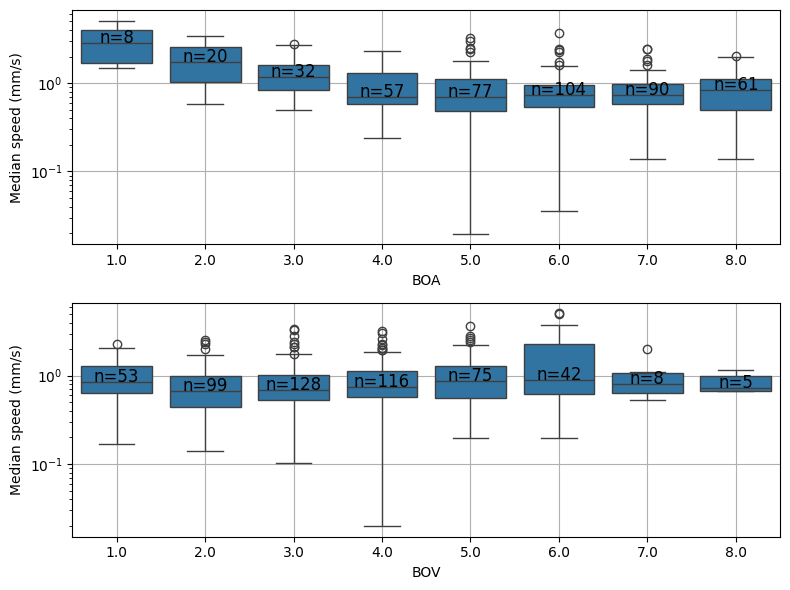

In [22]:
bo_var_name = 'v_mm2s'
max_bo = 8
f = plt.figure(figsize=(8, 6))
v_mm2s_stat = {}
for i, bo_name in enumerate(['BOA', 'BOV']): 
    vis_df = edge_f_t[(edge_f_t[bo_name] >= 1) & (edge_f_t[bo_name] <= max_bo) & (edge_f_t[bo_var_name] > 0) 
                      & ((edge_f_t['p_v_rev_frac'] < 0.1))]
    a = f.add_subplot(2, 1, i+1)
    sns.boxplot(x=bo_name, y=bo_var_name, data=vis_df)
    # sns.violinplot(x=bo_name, y=bo_var_name, data=vis_df, inner='quartile')
    vis_g = vis_df.groupby(bo_name)[bo_var_name]
    vis_count = vis_g.count()
    vis_med = vis_g.median()
    for i, idx in enumerate(vis_count.index):
        a.text(i, vis_med[idx], f'n={vis_count[idx]}', ha='center', fontsize=12, color='black')
    v_mm2s_stat[bo_name] = vis_med
    a.set_xlabel(bo_name)
    a.set_ylabel("Median speed (mm/s)")
    a.grid()
    a.set_yscale('log')
f.tight_layout()

if save_fig_Q:
    fp = os.path.join(vis_folder, f"Edge_med_speed_vs_BO_max_{max_bo}_min_p_{min_num_p}.png")
    io.print_image_in_several_formats(f, fp)

In [23]:
v_mm2s_stat # Median

{'BOA': BOA
 1.0    2.846763
 2.0    1.718861
 3.0    1.164208
 4.0    0.699786
 5.0    0.693632
 6.0    0.728738
 7.0    0.736139
 8.0    0.827377
 Name: v_mm2s, dtype: float64,
 'BOV': BOV
 1.0    0.851337
 2.0    0.678964
 3.0    0.682964
 4.0    0.747379
 5.0    0.859596
 6.0    0.882581
 7.0    0.797803
 8.0    0.731179
 Name: v_mm2s, dtype: float64}

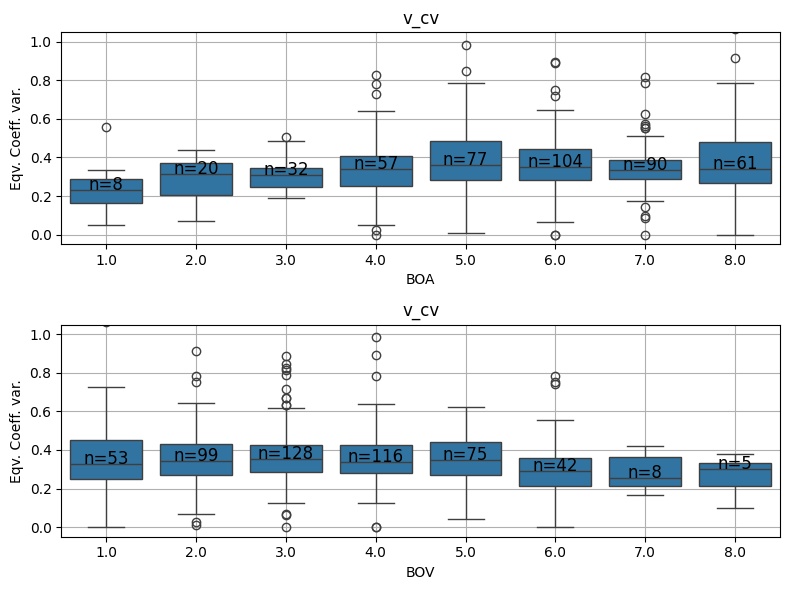

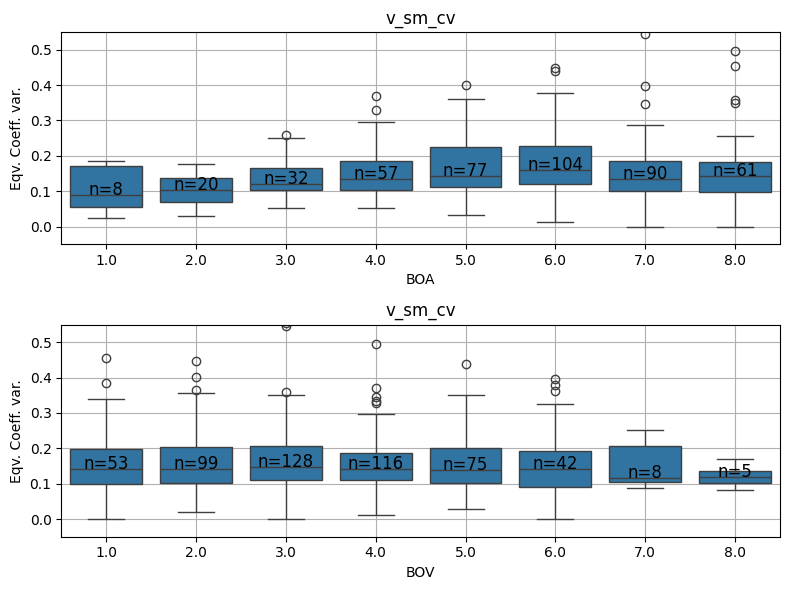

In [24]:
v_cv_stat = {}
for bo_var_name in ['v_cv', 'v_sm_cv']: 
    f = plt.figure(figsize=(8, 6))
    med_val = {}
    for i, bo_name in enumerate(['BOA', 'BOV']): 
        vis_df = edge_f_t[(edge_f_t[bo_name] >= 1) & (edge_f_t[bo_name] <= max_bo) & (edge_f_t['v_mm2s'] > 0) 
                        & ((edge_f_t['p_v_rev_frac'] < 0.1))]
        med_val['table'] = vis_df
        a = f.add_subplot(2, 1, i+1)
        sns.boxplot(x=bo_name, y=bo_var_name, data=vis_df)
        # sns.violinplot(x=bo_name, y=bo_var_name, data=vis_df, inner='quartile')
        vis_g = vis_df.groupby(bo_name)[bo_var_name]
        vis_count = vis_g.count()
        vis_med = vis_g.median()
        med_val[bo_name] = vis_med
        # print(vis_med)
        for i, idx in enumerate(vis_count.index):
            a.text(i, vis_med[idx], f'n={vis_count[idx]}', ha='center', fontsize=12, color='black')
        a.set_xlabel(bo_name)
        a.set_ylabel("Eqv. Coeff. var.")
        a.grid()
        if bo_var_name == 'v_cv': 
            a.set_ylim(-0.05, 1.05)
        elif bo_var_name == 'v_sm_cv': 
            a.set_ylim(-0.05, 0.55)
        a.set_title(bo_var_name)
    
    v_cv_stat[bo_var_name] = med_val
    f.tight_layout()
    if save_fig_Q: 
        fp = os.path.join(vis_folder, f"Edge_{bo_var_name}_eqv_cv_vs_BO_min_p_{min_num_p}.png")
        io.print_image_in_several_formats(f, fp)

In [58]:
tmp_merged_cv_stat = stat.compute_basic_statistics(v_cv_stat['v_cv']['table']['v_cv'].values) 
tmp_merged_cv_stat['mean'], tmp_merged_cv_stat['prctile_val'][[5, 6,7 ]]

(0.39267783551896873, array([0.2677621 , 0.33841226, 0.4204953 ]))

In [55]:
tmp_merged_cv_stat['prctile_val'][[5, 6, 7]], tmp_merged_cv_stat['num_data']

(array([0.2677621 , 0.33841226, 0.4204953 ]), 526)

In [ ]:
v_cv_stat['v_cv']['BOA'], v_cv_stat['v_cv']['BOV']

(BOA
 1.0    0.232541
 2.0    0.314530
 3.0    0.308755
 4.0    0.338025
 5.0    0.362662
 6.0    0.349354
 7.0    0.336141
 8.0    0.338556
 Name: v_cv, dtype: float64,
 BOV
 1.0    0.328322
 2.0    0.345048
 3.0    0.350849
 4.0    0.336855
 5.0    0.348461
 6.0    0.291040
 7.0    0.252845
 8.0    0.299497
 Name: v_cv, dtype: float64)

In [60]:
tmp_merged_smcv_stat = stat.compute_basic_statistics(v_cv_stat['v_sm_cv']['table']['v_sm_cv'].values) 
tmp_merged_smcv_stat['mean'],  tmp_merged_smcv_stat['prctile_val'][[5, 6, 7]]

(0.17683947361708557, array([0.10421682, 0.14015153, 0.20057936]))

In [56]:
v_cv_stat['v_sm_cv']['BOA'], v_cv_stat['v_sm_cv']['BOV']

(BOA
 1.0    0.088682
 2.0    0.104665
 3.0    0.121624
 4.0    0.135845
 5.0    0.143325
 6.0    0.160437
 7.0    0.135681
 8.0    0.142740
 Name: v_sm_cv, dtype: float64,
 BOV
 1.0    0.141865
 2.0    0.141851
 3.0    0.147786
 4.0    0.140611
 5.0    0.139282
 6.0    0.142040
 7.0    0.115693
 8.0    0.119588
 Name: v_sm_cv, dtype: float64)

### Node flow configuration vs branch order

In [26]:
node_feature_t = pd.DataFrame(node_features)

[ 7  9 22 25 26 27 17 18], [ 0  2  3 15 39 37 23 11], 151, 130
[ 6 28 42 33 35 13  4  1], [30 32 25 28 10  7  6  1], 162, 139


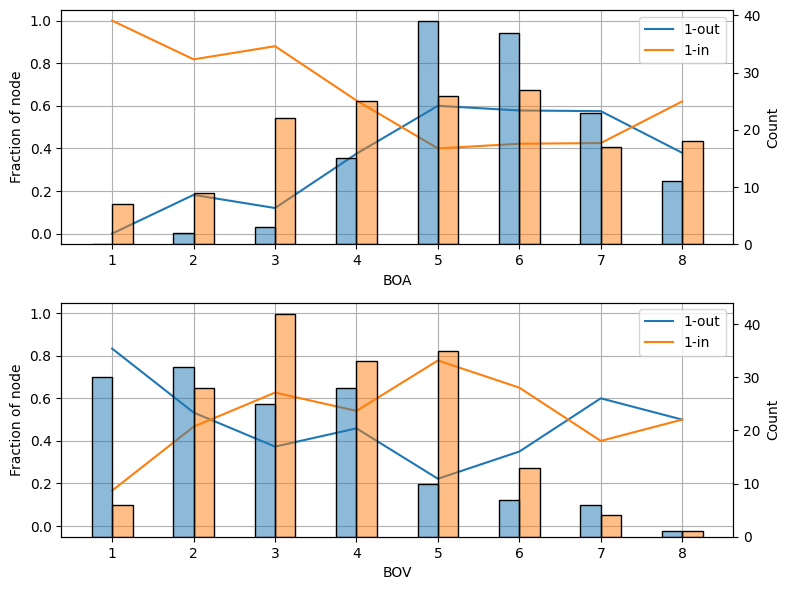

In [27]:
f = plt.figure(figsize=(8, 6))
for i, bo_name in enumerate(['BOA', 'BOV']): 
    vis_df = node_feature_t[(node_feature_t[bo_name] >= 1) & (node_feature_t[bo_name] <= 8) & (node_feature_t['num_unknown'] == 0)]
    vis_df = vis_df[(vis_df['num_in'] == 1) | (vis_df['num_out'] == 1)]

    vis_g = vis_df.groupby(bo_name)
    vis_gm = vis_g.mean()
    vis_x = vis_gm['is_1_in_Q'].index.values
    vis_avg_in = vis_gm['is_1_in_Q'].values
    vis_avg_out = vis_gm['is_1_out_Q'].values
    
    vis_g = vis_df.groupby(bo_name)
    vis_count = vis_g.sum()
    vis_count_in = vis_count['is_1_in_Q'].values
    vis_count_out = vis_count['is_1_out_Q'].values
    print(f"{vis_count_in}, {vis_count_out}, {np.sum(vis_count_in)}, {np.sum(vis_count_out)}")
    a = f.add_subplot(2, 1, i+1)
    a.plot(vis_x, vis_avg_out, label='1-out')
    a.plot(vis_x, vis_avg_in, label='1-in')
    a2 = a.twinx()
    sns.histplot(data=vis_df, x=bo_name, hue='is_1_in_Q', bins=np.arange(0.5, 9.5), multiple="dodge", kde=False, alpha=0.5, legend=False, shrink=0.5)
    a.set_xlabel(bo_name)
    a.set_ylabel("Fraction of node")
    a.grid()
    a.legend()
    a.set_ylim([-0.05, 1.05])
    f.tight_layout()

### 1-in-N-out node partition fraction

In [22]:
min_pe_length = 10
min_ce_length = 10
min_data = 25

In [23]:
# If the child edge has an endpoint, it should be long enough so that the upstream particle can be tracked. 
# tmp_valid_child_Q = np.all(np.logical_or(n_fbf_data['c_e_num_ep'] == 0, n_fbf_data['c_e_length'] > min_ce_length), axis=1)
# tmp_sufficient_data_Q = np.logical_and(n_fbf_data['p_num_cell'] >= min_data, n_fbf_data['p_e_length'].flatten() > min_pe_length)
# tmp_valid_Q = np.logical_and(tmp_valid_child_Q, tmp_sufficient_data_Q)
tmp_valid_Q = n_fbf_data['p_num_cell'] >= min_data
tmp_valid_Q = np.logical_and(tmp_valid_Q, np.logical_and(n_fbf_data['BOA'] >= 1, n_fbf_data['BOA'] <= 8))
tmp_valid_Q = np.logical_and(tmp_valid_Q, np.all(np.isfinite(n_fbf_data['c_ps_p_m']), axis=1))
tmp_valid_Q = np.logical_and(tmp_valid_Q, np.all(np.isfinite(n_fbf_data['c_avg_vf_r']), axis=1))
vis_fbf_data = util.mask_data_in_dict(n_fbf_data, tmp_valid_Q)

In [24]:
vis_fb_vs_BOA_t = pd.DataFrame({'node_label': vis_fbf_data['key'],
                          'BOA': vis_fbf_data['BOA'].astype(np.uint16), 
                          'p_c1': np.max(vis_fbf_data['c_ps_p_m'], axis=1), 
                          'v_bias_ratio': 2 * (np.max(vis_fbf_data['c_avg_v_r'], axis=1) - 0.5), 
                          'v_raw_bias_ratio': 2 * (np.max(vis_fbf_data['c_avg_v_r_raw'], axis=1) - 0.5), 
                          'vf_bias_ratio':  2* (np.max(vis_fbf_data['c_avg_vf_r'], axis=1) - 0.5)})
vis_fb_vs_BOA_t.groupby('BOA').count()

node_label  p_c1  v_bias_ratio  v_raw_bias_ratio  vf_bias_ratio
BOA                                                                 
1             6     6             6                 6              6
2             8     8             8                 8              8
3            20    20            20                20             20
4            18    18            18                18             18
5            18    18            18                18             18
6            22    22            22                22             22
7            14    14            14                14             14
8            12    12            12                12             12

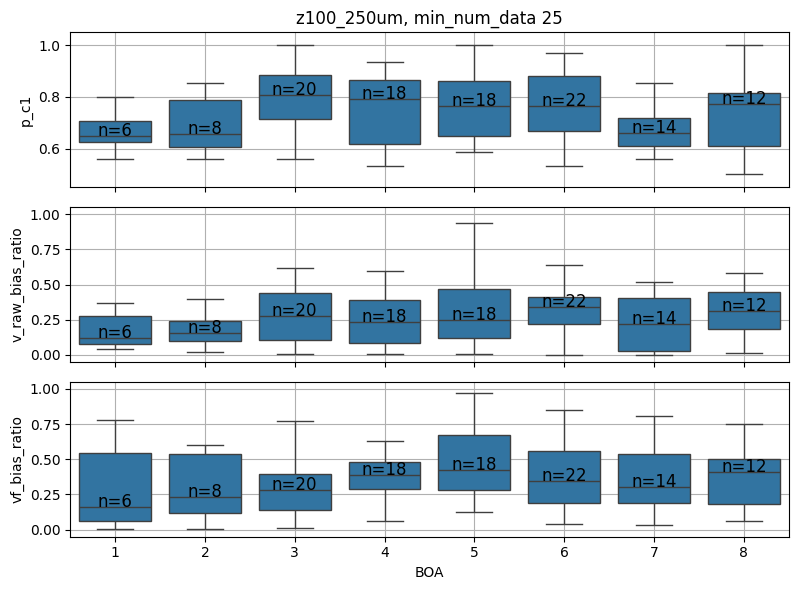

In [66]:
y_var_name = 'p'
bo_name = 'BOA'
f, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
for i, y_var_name in enumerate(['p_c1', 'v_raw_bias_ratio', 'vf_bias_ratio']): 
    # a = f.add_subplot()
    a = axes[i]
    sns.boxplot(ax=a, x=bo_name, y=y_var_name, data=vis_fb_vs_BOA_t)
    # sns.violinplot(x=bo_name, y=bo_var_name, data=vis_df, inner='quartile')
    vis_g = vis_fb_vs_BOA_t.groupby(bo_name)[y_var_name]
    vis_count = vis_g.count()
    vis_med = vis_g.median()
    for t_x, idx in enumerate(vis_count.index):
        a.text(t_x, vis_med[idx], f'n={vis_count[idx]}', ha='center', fontsize=12, color='black')
    a.grid()
    if i == 0: 
        a.set_title(f"{z_folder_name}, min_num_data {min_data}")
        a.set_ylim(0.45, 1.05)
    else: 
        a.set_ylim(-0.05, 1.05)
    if i != 2: 
        a.set_xlabel('')
        a.set_xticks

f.tight_layout()
if save_fig_Q: 
    fp = os.path.join(vis_folder, f"{z_folder_name}_phase_seperation_p_c1_vs_BOA_min_data_{min_data}.png")
    io.print_image_in_several_formats(f, fp)

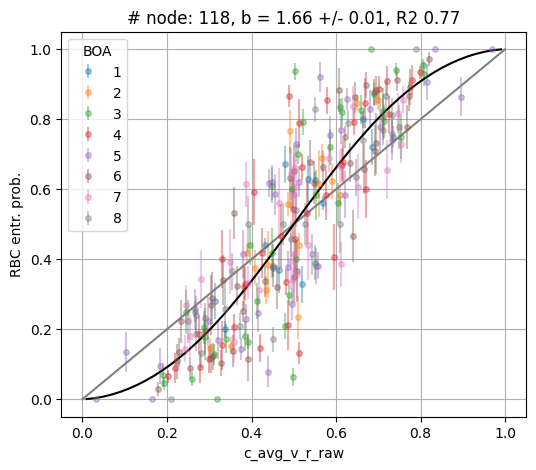

In [67]:
# Plot the phase seperation by branch order
tmp_idx_list, tmp_bo_list = util.bin_data_to_idx_list(vis_fbf_data['BOA'].astype(np.int16))
vis_xn = 'c_avg_v_r_raw'
# vis_xn = 'c_avg_vf_r'
f = plt.figure(figsize=(6, 5))
a1 = f.add_subplot()
fit_result = {}
for tmp_idx, tmp_bo in zip(tmp_idx_list, tmp_bo_list): 
    tmp_x = vis_fbf_data[vis_xn][tmp_idx, :].flatten()
    tmp_y = vis_fbf_data['c_ps_p_m'][tmp_idx, :].flatten()
    tmy_ye = vis_fbf_data['c_ps_p_mse'][tmp_idx, :].flatten()
    # if vis_xn == 'c_avg_v_r_raw': 
    #     tmp_xe = vis_fbf_data[f'{vis_xn}_se'][tmp_idx, :].flatten()
    #     a1.errorbar(tmp_x, tmp_y, tmy_ye, tmp_xe, alpha=0.4, linestyle='none', fmt='o', label=f"{tmp_bo}", markersize=4)
    # else: 
    #     a1.errorbar(tmp_x, tmp_y, tmy_ye, alpha=0.4, linestyle='none', fmt='o', label=f"{tmp_bo}", markersize=4)
    a1.errorbar(tmp_x, tmp_y, tmy_ye, alpha=0.4, linestyle='none', fmt='o', label=f"{tmp_bo}", markersize=4)
    tmp_fit_reuslt = NFTAnalysis.fit_phase_seperation_data(tmp_x, tmp_y)
    fit_result[tmp_bo] = tmp_fit_reuslt

fit_result = util.dict_of_dict_to_dict_of_array(fit_result)

a1.legend(title='BOA')
a1.grid()
a1.plot([0, 1], [0, 1], 'gray')
a1.set_xlabel(f"{vis_xn}")
a1.set_ylabel(f"RBC entr. prob.")

fig_avg = NFTAnalysis.fit_phase_seperation_data(vis_fbf_data[vis_xn].flatten(), vis_fbf_data['c_ps_p_m'].flatten(), visQ=False)
lr_b = fig_avg['b']
plt_x = np.linspace(0.01, 0.99, 50)
plt_y = (plt_x ** lr_b / (plt_x ** lr_b + (1 - plt_x) ** lr_b))
a1.plot(plt_x, plt_y, 'k', label=f'b = {lr_b:.2f}')

a1.set_title(f"# node: {vis_fbf_data['BOA'].size}, b = {lr_b:.2f} +/- {fig_avg['b_e']:.2f}, R2 {fig_avg['r2']:.2f}")
# a1.set_aspect('equal')
a1.set_xlim(-0.05, 1.05)
if save_fig_Q: 
    fp = os.path.join(vis_folder, f"{z_folder_name}_phase_seperation_etr_prob_vs_{vis_xn}_min_data_{min_data}.png")
    io.print_image_in_several_formats(f, fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/z100_250um_BOA_6_phase_seperation_etr_prob_vs_c_avg_v_r_raw_min_data_25.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/z100_250um_BOA_6_phase_seperation_etr_prob_vs_c_avg_v_r_raw_min_data_25.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/z100_250um_BOA_6_phase_seperation_etr_prob_vs_c_avg_v_r_raw_min_data_25.png


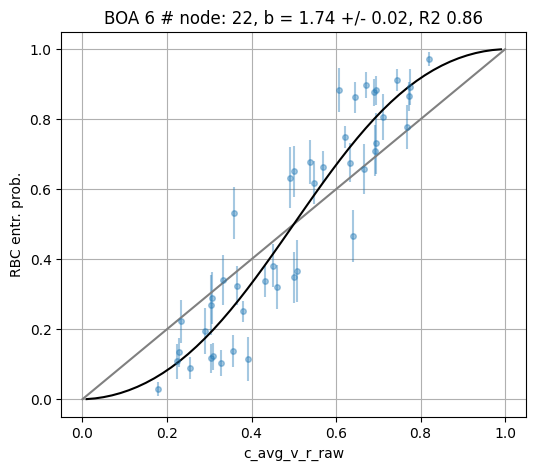

In [71]:
vis_BOA = 6
f = plt.figure(figsize=(6, 5))
a1 = f.add_subplot()
tmp_idx = tmp_idx_list[np.nonzero(tmp_bo_list == vis_BOA)[0][0]]
tmp_x = vis_fbf_data[vis_xn][tmp_idx, :].flatten()
tmp_y = vis_fbf_data['c_ps_p_m'][tmp_idx, :].flatten()
tmy_ye = vis_fbf_data['c_ps_p_mse'][tmp_idx, :].flatten()
# if vis_xn == 'c_avg_v_r_raw': 
#     tmp_xe = vis_fbf_data[f'{vis_xn}_se'][tmp_idx, :].flatten()
#     a1.errorbar(tmp_x, tmp_y, tmy_ye, tmp_xe, alpha=0.4, linestyle='none', fmt='o', label=f"{tmp_bo}", markersize=4)
# else: 
#     a1.errorbar(tmp_x, tmp_y, tmy_ye, alpha=0.4, linestyle='none', fmt='o', label=f"{tmp_bo}", markersize=4)
a1.errorbar(tmp_x, tmp_y, tmy_ye, alpha=0.4, linestyle='none', fmt='o', label=f"{tmp_bo}", markersize=4)
tmp_fit_reuslt = NFTAnalysis.fit_phase_seperation_data(tmp_x, tmp_y)
a1.grid()
a1.plot([0, 1], [0, 1], 'gray')
a1.set_xlabel(f"{vis_xn}")
a1.set_ylabel(f"RBC entr. prob.")

lr_b = tmp_fit_reuslt['b']
plt_x = np.linspace(0.01, 0.99, 50)
plt_y = (plt_x ** lr_b / (plt_x ** lr_b + (1 - plt_x) ** lr_b))
a1.plot(plt_x, plt_y, 'k', label=f'b = {lr_b:.2f}')
a1.set_title(f"BOA {vis_BOA} # node: {tmp_idx.size}, b = {lr_b:.2f} +/- {tmp_fit_reuslt['b_e']:.2f}, R2 {tmp_fit_reuslt['r2']:.2f}")

if save_fig_Q or True: 
    fp = os.path.join(vis_folder, f"{z_folder_name}_BOA_{vis_BOA}_phase_seperation_etr_prob_vs_{vis_xn}_min_data_{min_data}.png")
    io.print_image_in_several_formats(f, fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/z100_250um_phase_seperation_c_avg_v_r_raw_fit_para_vs_BOA_min_data_25.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/z100_250um_phase_seperation_c_avg_v_r_raw_fit_para_vs_BOA_min_data_25.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/z100_250um_phase_seperation_c_avg_v_r_raw_fit_para_vs_BOA_min_data_25.png


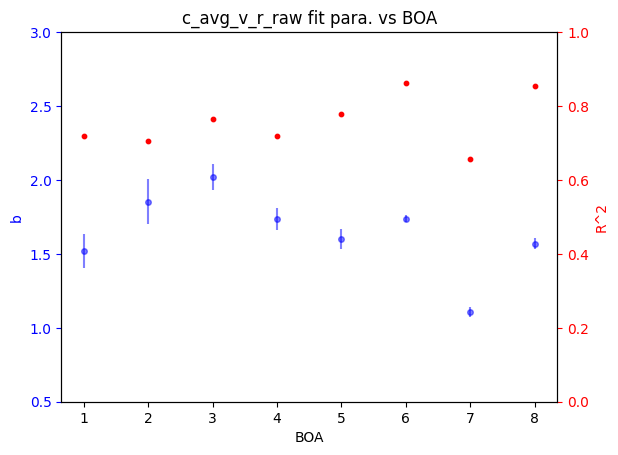

In [70]:
f, a = plt.subplots()
a.errorbar(fit_result['key'], fit_result['b'], fit_result['b_e'], alpha=0.5, linestyle='none', fmt='o', label=f"{tmp_bo}", markersize=4, color='b')
a1 = a.twinx()

a.set_xlabel(f"BOA")
a.set_ylabel(f"b", color='b')
a.tick_params(axis='y', colors='b')
a.set_title(f"{vis_xn} fit para. vs BOA")
a.set_ylim(0.5, 3.0)

a1.scatter(fit_result['key'], fit_result['r2'], 10, 'r')
a1.set_ylabel("R^2", color='r')
a1.tick_params(axis='y', colors='r')
a1.set_ylim(0, 1)

if save_fig_Q or True: 
    fp = os.path.join(vis_folder, f"{z_folder_name}_phase_seperation_{vis_xn}_fit_para_vs_BOA_min_data_{min_data}.png")
    io.print_image_in_several_formats(f, fp)

## Example: Single edge traces

In [28]:
fg.get_node_connected_edge_flow_dir(107, fg.edge_v_pxl) # node 107, 135, BOA = 2, 2-in-1-out

(array([255, 306, 330]), array([1, 0, 0], dtype=int8))

In [20]:
mv_avg_wd_t = 0.5
mv_avg_wd = int(mv_avg_wd_t * data_info['frame_rate_Hz'])
mv_min_num = 3

std_para = {'vxl_size_um': voxel_size_um, 
            'frame_rate_Hz': data_info['frame_rate_Hz'], 
            'labeled_fraction': cell_labeled_fraction}

In [18]:
save_fig_Q = False

Length 25.36, ep2ep vec [ 2. -4. 23.], est_v -11.848560724089314
Number of endpoints: 0


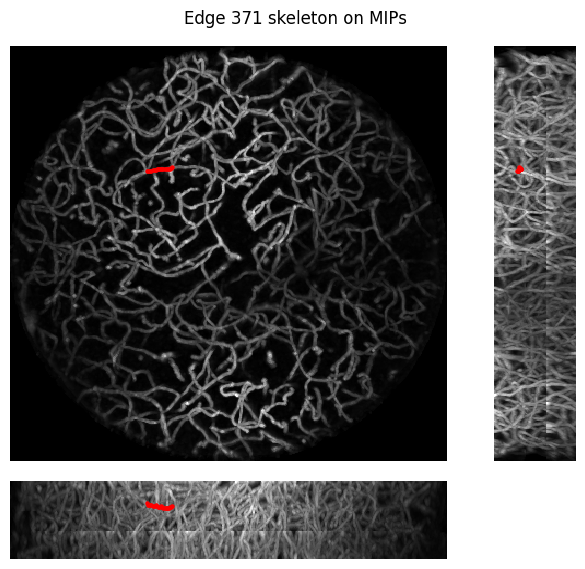

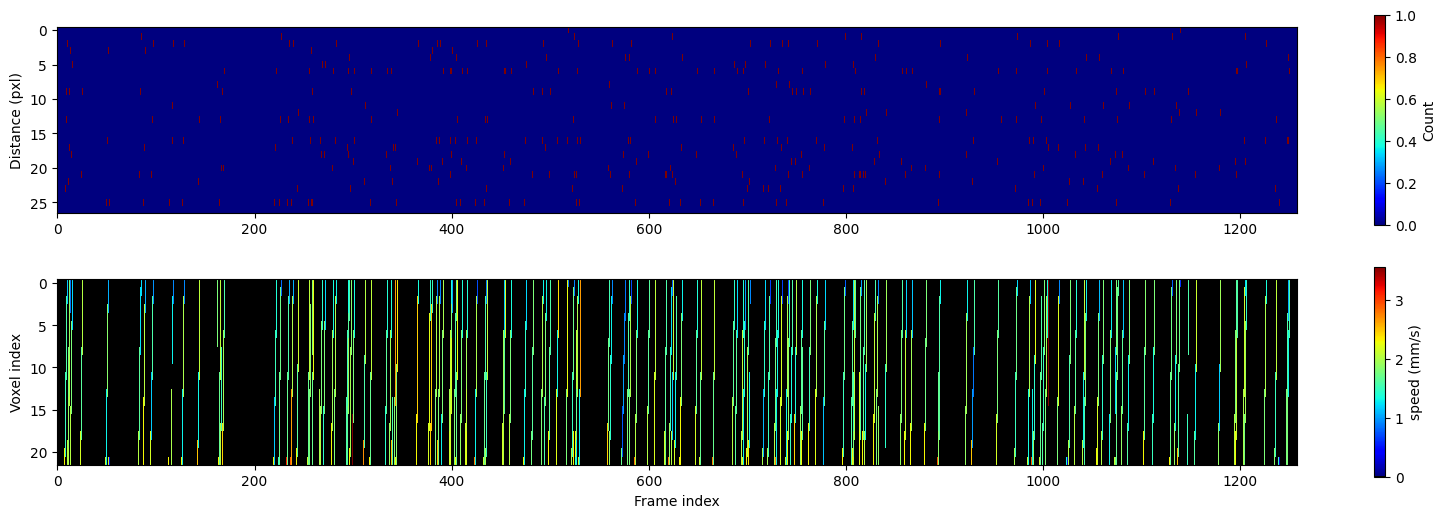

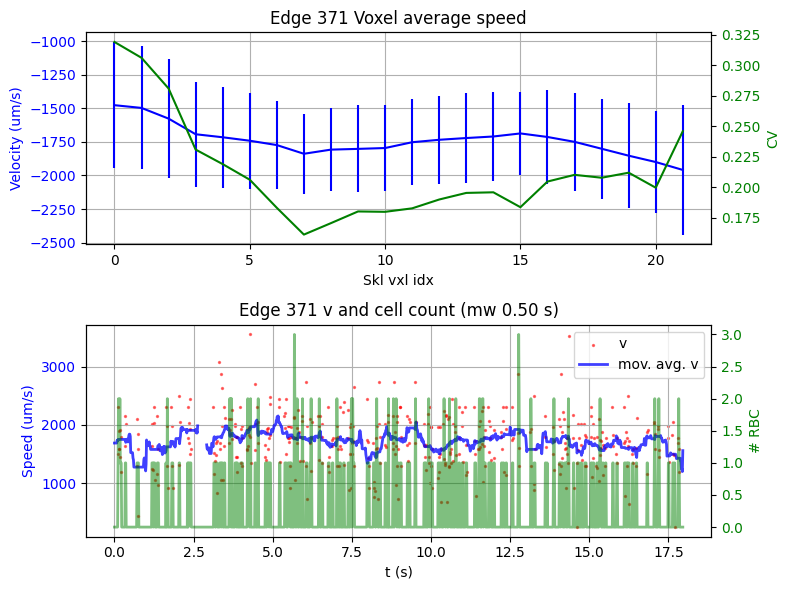

In [21]:
use_data = 'ns'
# test_el = 61
test_el = 371 # figure visualization
if test_el in p_el_to_idx: 
    if use_data == 'all':
        tmp_edge_table = tk_data['tracking_all'].iloc[all_el_to_idx[test_el]]
    elif use_data == 'ns': 
        tmp_edge_table = ptrace_result.iloc[p_el_to_idx[test_el]]
    test_ef = fg.get_edgeflow_object(test_el, detection_in_edge=tmp_edge_table)
    print(f"Length {test_ef.length:.2f}, ep2ep vec {np.round(test_ef.vec_ep2ep, decimals=2)}, est_v {fg.edge_v_pxl[test_el]}")
    print(f"Number of endpoints: {test_ef.num_endpoints}")
    
    tmp_stat = test_ef.analyze_edge_spatiotemporal_dynamics(mv_avg_wd, mv_min_num, **std_para)
    # tmp_stat = edges_traces[test_el]
    # dm_info = test_ef.iterative_est_avg_velocity_from_detection_map(test_ef.detect_map, vis_Q=True)
    f = test_ef.vis_w_3_mip(vsl_mips, figsize=(6, 6))
    if save_fig_Q: 
        fp = os.path.join(vis_folder, f'Example_edge_{test_el}_3_mips.png')
        io.print_image_in_several_formats(f, fp)
    f = test_ef.vis_detection_and_vxl_v_map(frame_range=None, pxl2f_to_mm2s=1/mm2s_to_pxl2s)
    if save_fig_Q:
        fp = os.path.join(vis_folder, f'Example_edge_{test_el}_detection_and_vxl_v_map.png')
        io.print_image_in_several_formats(f, fp)
    # test_ef.detections.head(10)
    f = NFTVis.vis_single_edge_stat_traces(tmp_stat)
    if save_fig_Q: 
        fp = os.path.join(vis_folder, f'Example_edge_{test_el}_skl_v_and_avg_v_traces.png')
        io.print_image_in_several_formats(f, fp)
else: 
    print(f"Edge {test_el} does not have any detection.")

In [ ]:
tmp_stat_abs_v = tmp_stat.copy()
if tmp_stat_abs_v['skl_v_mean'].mean() < 0: 
    tmp_stat_abs_v['skl_v_mean'] = -tmp_stat_abs_v['skl_v_mean'][::-1]
f = NFTVis.vis_single_edge_stat_traces(tmp_stat_abs_v)
fp = os.path.join(vis_folder, f'Example_edge_{test_el}_abs_skl_v_and_avg_v_traces.png')
io.print_image_in_several_formats(f, fp)

In [32]:
tmp_stat['skl_v_mean'], tmp_stat['skl_v_std']

(array([-1476.07349806, -1496.4509908 , -1576.12492111, -1692.5818806 ,
        -1715.1156317 , -1740.93459488, -1773.2683688 , -1838.11732686,
        -1807.20792606, -1801.65640026, -1795.38176058, -1752.11983085,
        -1733.91072975, -1720.84529821, -1709.33964239, -1686.57605479,
        -1712.98304389, -1749.21484718, -1800.61755282, -1852.37740396,
        -1899.64823789, -1958.6070696 ]),
 array([471.22295132, 458.28184444, 443.01031796, 390.89566794,
        375.63604358, 359.01857011, 324.79783768, 296.30454474,
        308.31872232, 324.63190204, 322.95963941, 320.1728253 ,
        329.41767883, 336.24621898, 334.85304542, 309.79542373,
        350.67478173, 367.7059557 , 374.26094318, 392.68384974,
        379.29754667, 481.85813794]))

In [33]:
stat.compute_basic_statistics(tmp_stat['p_t_v_mean_sm'])

{'num_data': 1239,
 'mean': -1716.536242242308,
 'std': 148.3078317161867,
 'cv': 0.08639947591345493,
 'max': -1198.1125914497438,
 'min': -2155.5879378670634,
 'median': -1737.944541354339,
 'num_bins': 10,
 'hist_count': array([  8,  35, 128, 276, 345, 227, 148,  38,   8,  26]),
 'bin_val': array([-2107.71417055, -2011.9666359 , -1916.21910126, -1820.47156662,
        -1724.72403198, -1628.97649734, -1533.2289627 , -1437.48142805,
        -1341.73389341, -1245.98635877]),
 'bin_width': array([95.74753464, 95.74753464, 95.74753464, 95.74753464, 95.74753464,
        95.74753464, 95.74753464, 95.74753464, 95.74753464, 95.74753464]),
 'probability': array([0.00645682, 0.02824859, 0.10330912, 0.22276029, 0.27845036,
        0.18321227, 0.11945117, 0.0306699 , 0.00645682, 0.02098467]),
 'pdf': array([6.74358879e-05, 2.95032010e-04, 1.07897421e-03, 2.32653813e-03,
        2.90817267e-03, 1.91349332e-03, 1.24756393e-03, 3.20320468e-04,
        6.74358879e-05, 2.19166636e-04]),
 'cdf': array

### Plot all the exit trajectories that originated from the test_ef edge.

In [34]:
test_el = 61
tmp_edge_table = ptrace_result.iloc[p_el_to_idx[test_el]]
test_ef = fg.get_edgeflow_object(test_el, detection_in_edge=tmp_edge_table)

In [35]:
test_e_p_ids = np.unique(test_ef.detections.particle.values)
test_e_p_len = np.asarray([p_pid_to_idx[i].size for i in test_e_p_ids])
tmp_idx = np.argsort(test_e_p_len)[::-1]
test_e_p_ids = test_e_p_ids[tmp_idx]
test_e_p_len = test_e_p_len[tmp_idx]

In [36]:
vis_traces = {}
for tmp_p in test_e_p_ids: 
    tmp_detect = ptrace_result.iloc[p_pid_to_idx[tmp_p]]
    tmp_end_edge = tmp_detect.edge_label.values[-1]
    tmp_length = tmp_detect.shape[0]
    tmp_exit_Q = (tmp_detect.exit_ind.values[-1] >= 0)
    if tmp_exit_Q and (tmp_end_edge >= 0): 
        if tmp_end_edge not in vis_traces: 
            vis_traces[tmp_end_edge] = [tmp_p, tmp_length, tmp_exit_Q]
        elif vis_traces[tmp_end_edge][1] < tmp_length: 
            vis_traces[tmp_end_edge] = [tmp_p, tmp_length, tmp_exit_Q]

In [37]:
vis_p = [p[0] for p in vis_traces.values()]
p_pos_d = {k : ptrace_result.iloc[p_pid_to_idx[k]][['z', 'y', 'x']].to_numpy().T for k in vis_p}

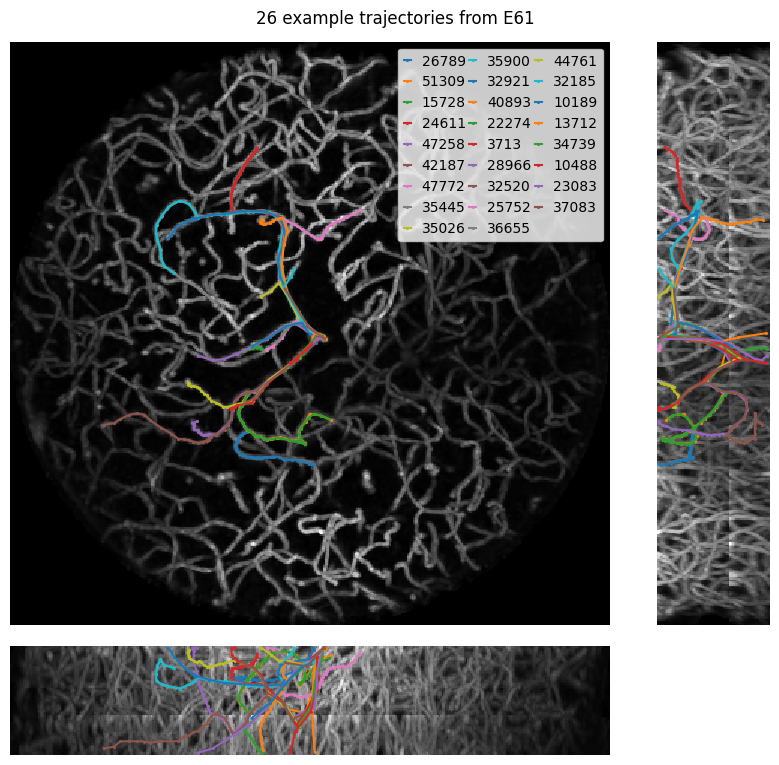

In [38]:
f = vis.vis_mips_w_ptl(vsl_mips, p_pos_d, vis_type=['line'], show_legend_Q=True, fig_title=f"{len(vis_p)} example trajectories from E{test_el}")
if save_fig_Q: 
    fp = os.path.join(vis_folder, f"Example_{len(vis_p)}_single_cell_trajectories_from_E{test_el}.png")
    io.print_image_in_several_formats(f, fp)

### Single cell trajectory

In [19]:
tmp_p_id = 26789  
tmp_detect = ptrace_result.iloc[p_pid_to_idx[tmp_p_id]]
tmp_detect.edge_label.values

array([ 61, 295, 489, 489, 498, 498,  -1, 412, 412, 412, 412, 412, 412,
       412, 412,  -1, 391,  -1,  -1, 401, 401, 401, 401, 401, 401, 401,
       401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401,
       401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401,
       401, 401, 401, 401, 180, 180, 180, 180, 180, 180,  97,  97])

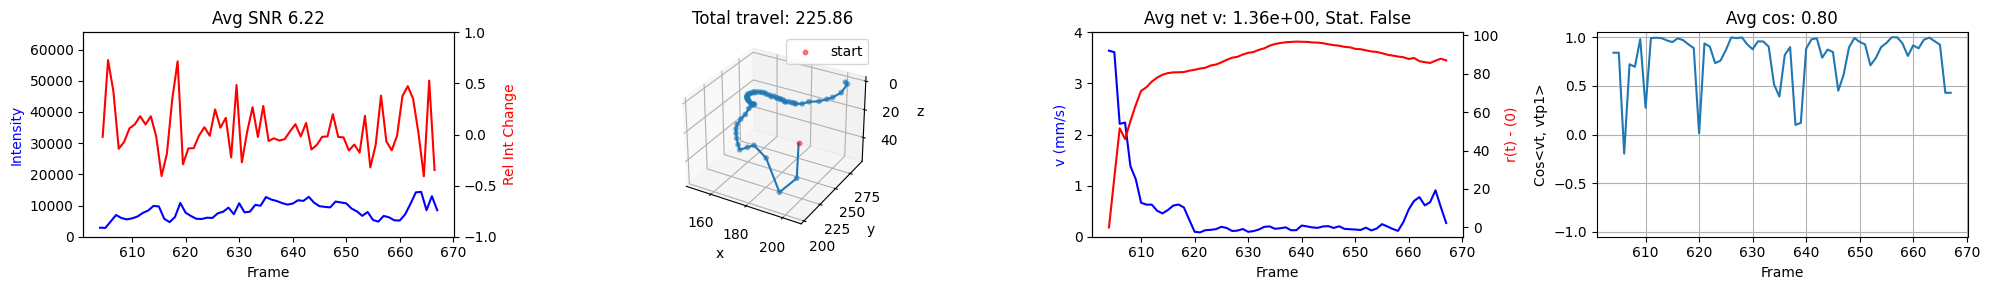

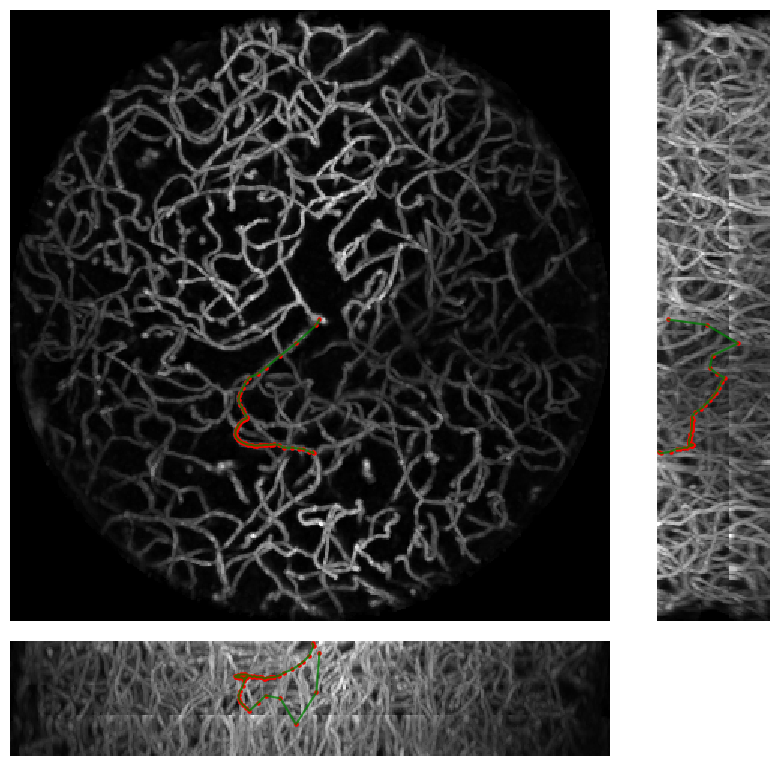

In [20]:
# tmp_p_id = 26789
tmp_p = particle.Particle(ptrace_result.iloc[p_pid_to_idx[tmp_p_id]])
f = tmp_p.vis_traces(vxl2f_to_mm2s= 1 / mm2s_to_pxl2s)
if save_fig_Q: 
    fp = os.path.join(vis_folder, f"Example_single_trajectory_pid_{tmp_p_id}_traces.png")
    io.print_image_in_several_formats(f, fp)

f = tmp_p.vis_traj_w_mips(vsl_mips)
if save_fig_Q:
    fp = os.path.join(vis_folder, f"Example_single_trajectory_pid_{tmp_p_id}_3_mips.png")
    io.print_image_in_several_formats(f, fp)

## Example: Skeleton velocity from artery

In [41]:
save_fig_Q = False

/home/xij072/Documents/Github/Network_flow/NFT/visualization.py:62: RuntimeWarning:

Mean of empty slice

/home/xij072/Software/miniconda3/envs/d2l/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning:

Degrees of freedom <= 0 for slice.



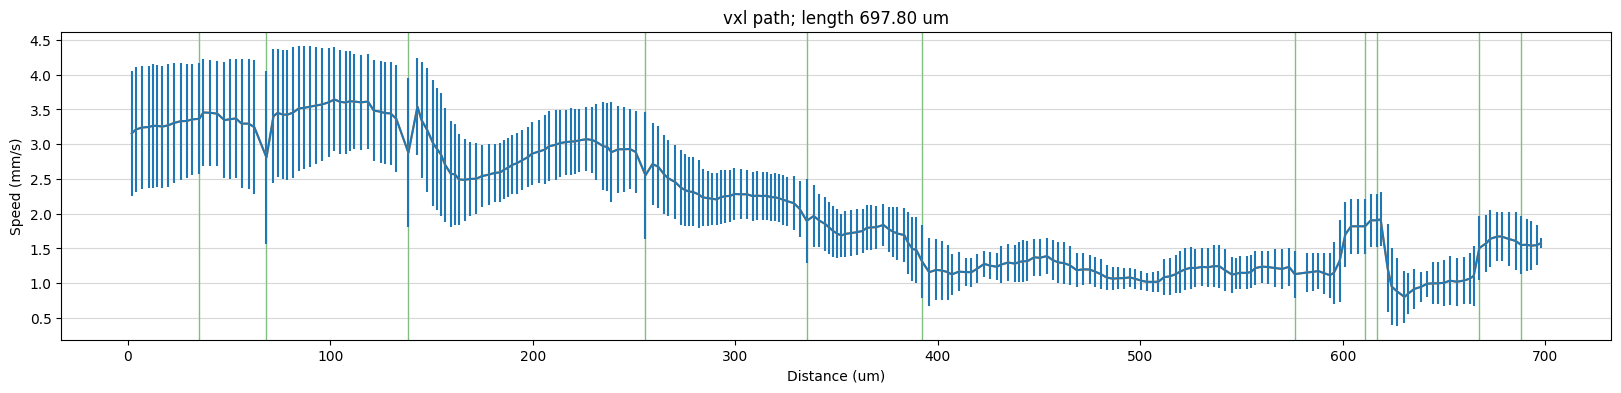

In [93]:
source_edge = 61 # PA
target_edge = 54 # 54

# Figure: 
# source_edge = 61 # PA
# target_edge = 54
f, edge_path = NFTVis.vis_vxl_path_v_between_two_edges(source_edge, target_edge, fg, voxel_size_um=2, mm2s_to_pxl2s=mm2s_to_pxl2s, merge_node_Q=True)
if save_fig_Q:
    fp = os.path.join(vis_folder, f"Example_edge_path_{source_edge}_to_{target_edge}_vxl_speed_m_n_sd.png")
    io.print_image_in_several_formats(f, fp)

In [57]:
edge_features['type'][edge_path]

array([2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 3.])

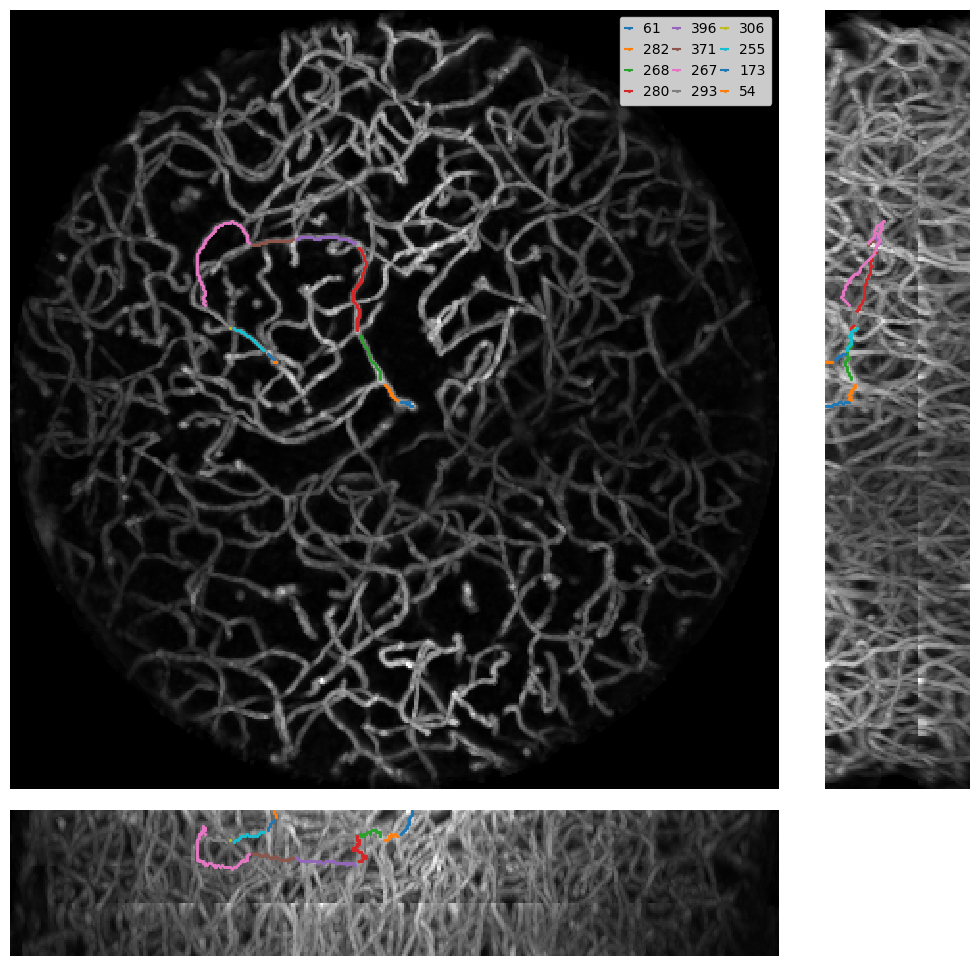

In [58]:
# print(f"Edge type: {edge_features['type'][edge_path]}")
f = fg.vis_edges_with_mips(edge_path, vsl_mips, legend_type='label')
if save_fig_Q:
    fp = os.path.join(vis_folder, f"Example_edge_path_{source_edge}_to_{target_edge}_w_3_mips.png")
    io.print_image_in_several_formats(f, fp)

## Example - non shortest path

In [42]:
vis_traces

{97: [26789, 64, True],
 86: [51309, 46, True],
 215: [15728, 43, True],
 134: [24611, 36, True],
 87: [47258, 35, True],
 850: [42187, 34, True],
 135: [47772, 30, True],
 173: [35445, 28, True],
 72: [35026, 25, True],
 293: [35900, 24, True],
 34: [32921, 19, True],
 494: [40893, 17, True],
 754: [22274, 13, True],
 83: [3713, 12, True],
 755: [28966, 12, True],
 244: [32520, 11, True],
 64: [25752, 8, True],
 158: [36655, 7, True],
 53: [44761, 7, True],
 43: [32185, 6, True],
 338: [10189, 6, True],
 620: [13712, 5, True],
 609: [34739, 5, True],
 738: [10488, 5, True],
 295: [23083, 4, True],
 268: [37083, 4, True]}

In [121]:
tmp_p_id = 51309
tmp_detect = ptrace_result.iloc[p_pid_to_idx[tmp_p_id]]
tmp_p_skl_ind = tmp_detect.skl_ind.values

In [122]:
tmp_p_skl_ind

array([ 561408, 3921403, 7444597, 6968985, 5372972, 5854168, 7136162,
       7296558, 7137357, 6818556, 6340153, 6180953, 5702152, 5223353,
       4744154, 4265356, 3786558, 3626959, 3307361, 2987763, 2668164,
       2668164, 2348166, 1708969, 1389371, 1228973,  908576,  908178,
        908180,  908182,  908986, 1069390, 1389792, 2030195, 2670196,
       3310196, 3629795, 4108994, 4268192, 4106992, 4106193, 3784197,
       2982200, 2501802, 1862607,  904215])

In [123]:
tmp_p_path_ind = []
tmp_e_path_label = []
for tmp_ind_0, tmp_ind_1 in zip(tmp_p_skl_ind[:-1], tmp_p_skl_ind[1:]): 
    tmp_path_node, tmp_l = fg.abs_g.compute_shortest_path_between_two_voxel_indices(tmp_ind_0, tmp_ind_1)
    tmp_path_vxl_ind, tmp_dir, tmp_edge_path, _ = fg.abs_g.get_voxel_path_from_node_path(tmp_path_node, tmp_ind_0, tmp_ind_1, include_node_Q=True, 
                                                                                         return_edge_path_Q=True)
    # assert (tmp_path_vxl_ind[0] == tmp_ind_0) and (tmp_ind_1 in tmp_path_vxl_ind[-4:])
    # print(f"From {tmp_ind_0} to {tmp_ind_1}, path length {tmp_l}, vxl path length {len(tmp_path_vxl_ind)}, dir {tmp_dir}")
    tmp_p_path_ind.append(tmp_path_vxl_ind)
    for tmp_e in tmp_edge_path:
        if tmp_e not in tmp_e_path_label:
            tmp_e_path_label.append(tmp_e)
tmp_p_path_ind_c = np.concatenate(tmp_p_path_ind)

In [124]:
tmp_e_path_label, edge_features['type'][np.asarray(tmp_e_path_label)]

([61, 295, 609, 489, 498, 591, 412, 391, 310, 215, 86],
 array([2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 3.]))

In [125]:
save_fig_Q = False

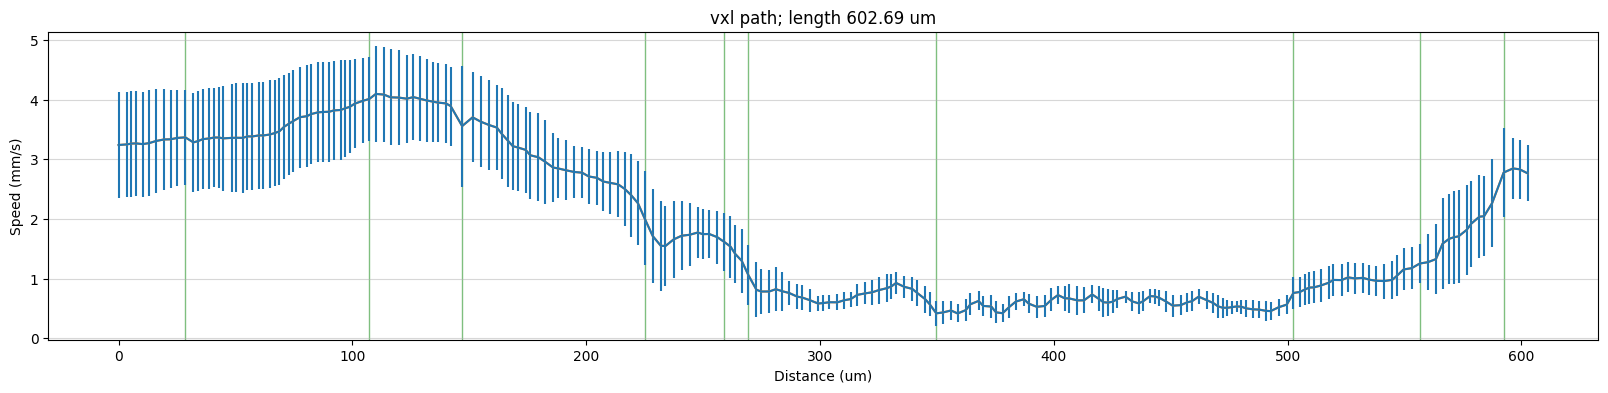

In [126]:
f, edge_path = NFTVis.vis_vxl_path_v(tmp_p_path_ind_c, fg, voxel_size_um=voxel_size_um, mm2s_to_pxl2s=mm2s_to_pxl2s, merge_node_Q=True)
if save_fig_Q:
    fp = os.path.join(vis_folder, f"Example_edge_path_{tmp_e_path_label[0]}_to_{tmp_e_path_label[-1]}_vxl_speed_m_n_sd.png")
    io.print_image_in_several_formats(f, fp)

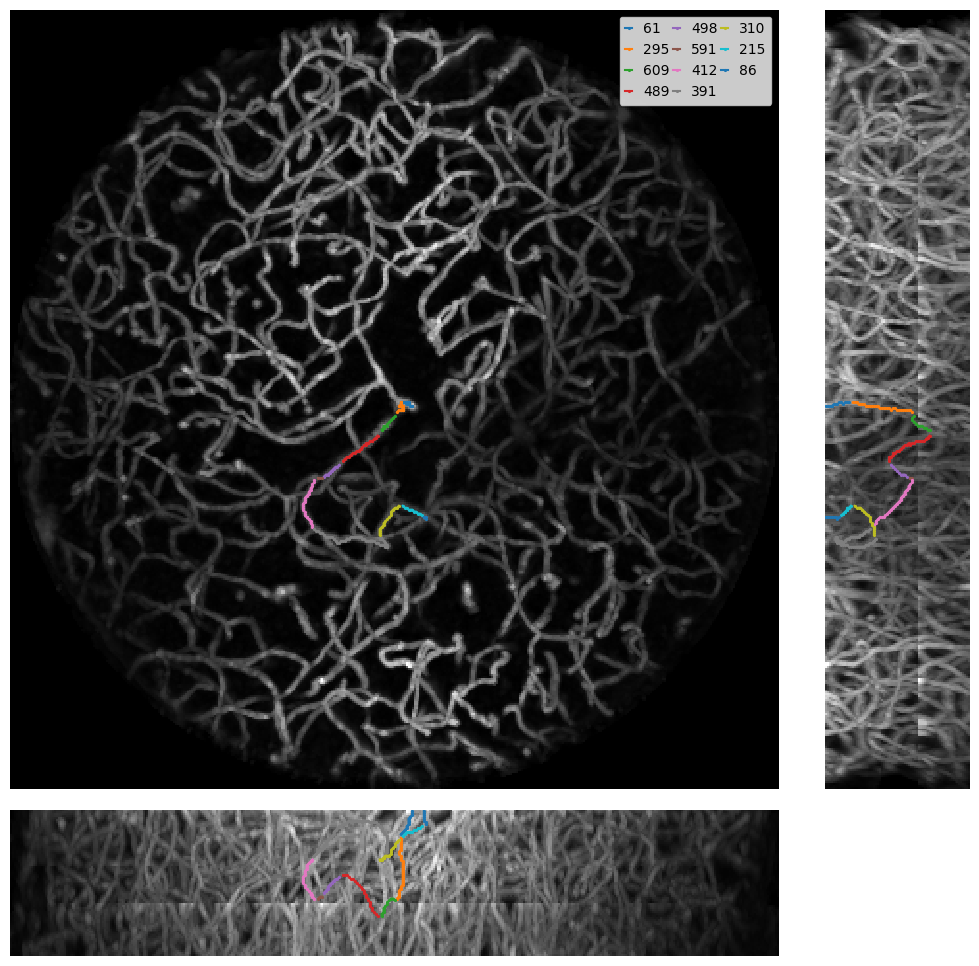

In [127]:
f = fg.vis_edges_with_mips(tmp_e_path_label, vsl_mips, legend_type='label')
if save_fig_Q:
    fp = os.path.join(vis_folder, f"Example_edge_path_{tmp_e_path_label[0]}_to_{tmp_e_path_label[-1]}_w_3_mips.png")
    io.print_image_in_several_formats(f, fp)

## Example: Pairwise trace correlaton matrix for segments near the artery tree

In [115]:
is_artery_w_1_ep_Q = np.logical_and(np.sum(fg.edge.connected_node_label == -1, axis=1) == 1, (edge_features['type'] == 2))
inflow_artery_el = np.nonzero(np.logical_and(fg.edge_v_pxl < 0, is_artery_w_1_ep_Q))[0]
print(f"Number of inflow artery segments: {inflow_artery_el.size}")
is_vein_w_1_ep_Q = np.logical_and(np.sum(fg.edge.connected_node_label == -1, axis=1) == 1, (edge_features['type'] == 3))
outflow_vein_el = np.nonzero(np.logical_and(fg.edge_v_pxl > 0, is_vein_w_1_ep_Q))[0]
print(f"Number of outflow vein segments: {outflow_vein_el.size}")

Number of inflow artery segments: 6
Number of outflow vein segments: 12


In [116]:
inflow_artery_el

array([  2,  41,  59,  61,  98, 100])

In [118]:
from collections import OrderedDict

In [119]:
# Get the tree structure
# Figure was visulized for #3 PA w/ ep 

artery_trees = OrderedDict()
artery_tree_l = []
ds_cutoff_order = 3
for tmp_idx in inflow_artery_el[[3]]: 
    tmp_ds_tree = fg.get_downstream_edges_in_tree(tmp_idx, cutoff_order=ds_cutoff_order) # might need a cutoff to certian order
    artery_trees |= tmp_ds_tree
    artery_tree_l.append(tmp_ds_tree)

# map the edge label to matrix indices 
dict_ael_to_idx = {}
list_idx_to_ael = []
n_count = 0
for k, v in artery_trees.items():
    for kk in ([k] + v): 
        if kk not in dict_ael_to_idx: 
            dict_ael_to_idx[kk] = n_count
            list_idx_to_ael.append(kk)
            n_count += 1

list_idx_to_ael = np.asarray(list_idx_to_ael)

vis_artery_tree = {}
for k, v in artery_trees.items():
    vis_artery_tree[dict_ael_to_idx[k]] = [dict_ael_to_idx[vv] for vv in v]

tree_el = list(dict_ael_to_idx.keys())
print(f"Number of edges in the tree: {len(tree_el)}")

Number of edges in the tree: 14


In [120]:
def count_num_edge_in_tree(tree): 
    el = []
    for k, v in tree.items():
        el.append(k)
        el += (v)
    el = set(el)
    return len(el)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/long_range_corr/PAE61_dso_3_e_t_c_flux_smp_corr_p_0.05_mats.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/long_range_corr/PAE61_dso_3_e_t_c_flux_smp_corr_p_0.05_mats.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/long_range_corr/PAE61_dso_3_e_t_c_flux_smp_corr_p_0.05_mats.png
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/long_range_corr/PAE61_dso_3_p_t_v_mean_sm_corr_p_0.05_mats.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/long_range_corr/PAE61_dso_3_p_t_v_mean_sm_corr_p_0.05_mats.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/long_range_corr/PAE61_dso_3_p_t_v_mean_sm_corr_p_0.05_mats.png


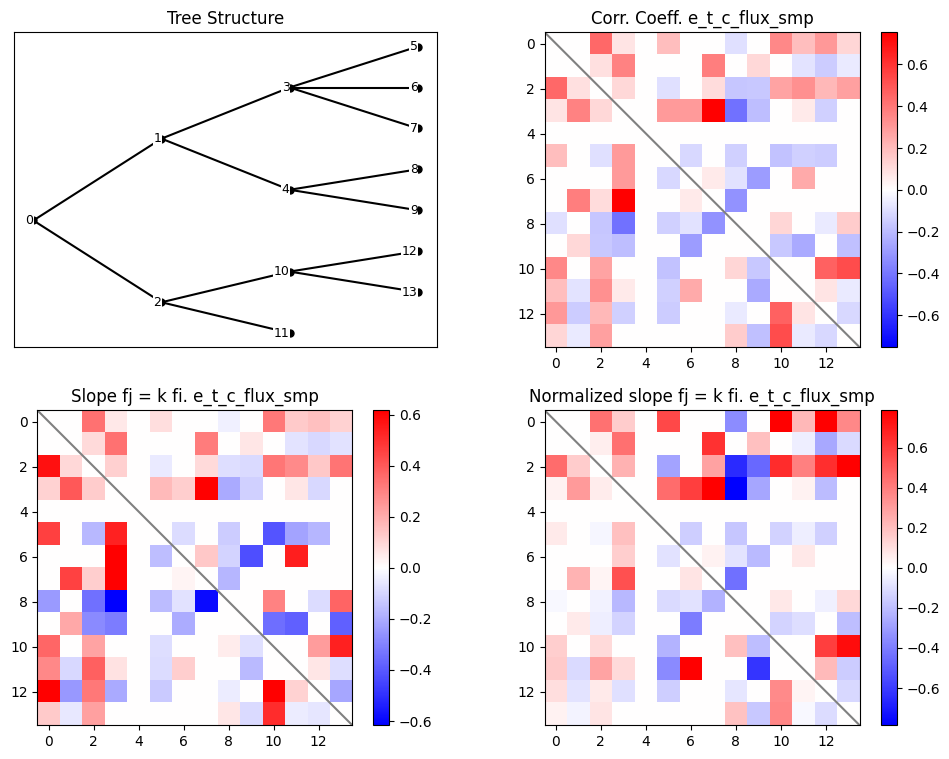

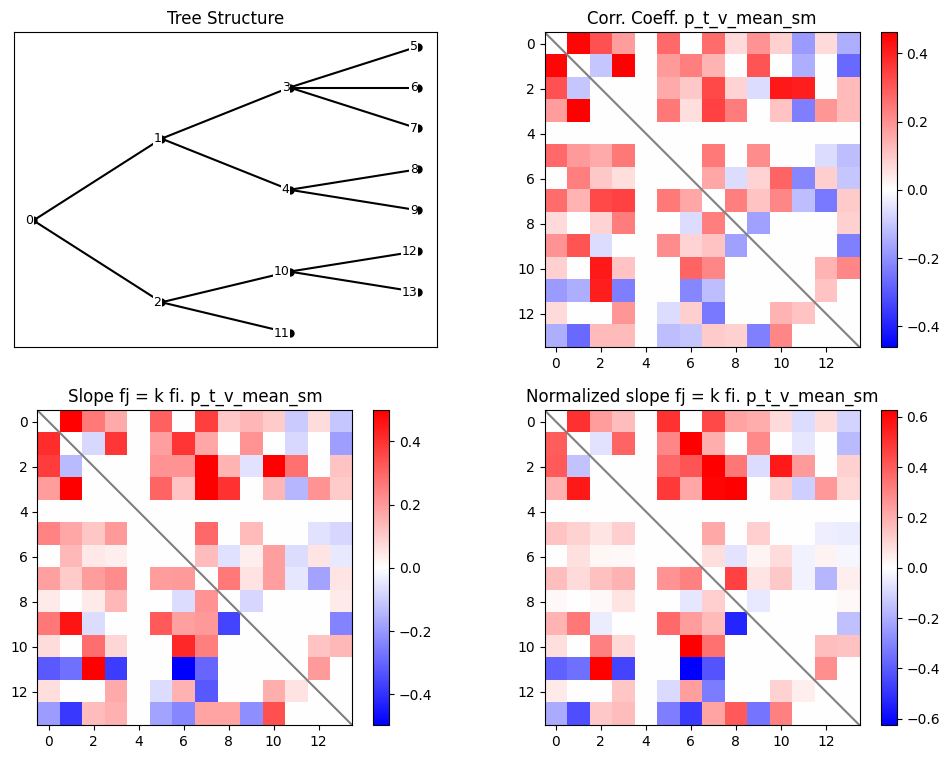

In [124]:
for trace_key in ['e_t_c_flux_smp', 'p_t_v_mean_sm']: 
    tree_edge_traces = np.abs(np.vstack([edges_traces[el][trace_key] if el in edges_traces else np.full((num_t_pts, ), np.nan) for el in tree_el]))
    is_invalid_edge_Q = np.logical_and(np.logical_and(edge_features['has_exit_ep_Q'], edge_features['length'] < 10),  
                                    np.logical_or(edge_features['l2v'] < 1, edge_features['length'] < 5))
    # is_invalid_edge_Q = np.logical_or(is_invalid_edge_Q, edge_features['l2v'] < 0.5)
    is_invalid_edge_Q = np.logical_or(is_invalid_edge_Q, edge_features['length'] < 5)
    tree_edge_invalid_Q = is_invalid_edge_Q[tree_el]
    tree_corr_info = stat.analyze_traces_corr_mat(tree_edge_traces, tree_edge_invalid_Q)

    ### 
    vis_num_edges_in_tree = np.asarray([count_num_edge_in_tree(t) for t in artery_tree_l])
    vis_line_x = np.cumsum(vis_num_edges_in_tree)
    p_value_th = 0.05
    p_value_mask = tree_corr_info['p'] > p_value_th
    vis_mat = tree_corr_info['corr']
    vis_mat[np.isnan(vis_mat)] = 0
    vis_mat[p_value_mask] = 0
    vis_slope_mat = tree_corr_info['k'].copy()
    vis_slope_mat[np.isnan(vis_slope_mat)] = 0
    vis_slope_mat[p_value_mask] = 0
    vis_slope_n_mat = tree_corr_info['k_n'].copy()
    vis_slope_n_mat[np.isnan(vis_slope_n_mat)] = 0
    vis_slope_n_mat[p_value_mask] = 0
    mat_cmap = 'bwr'

    f_layout = (2, 2)
    f = plt.figure(figsize=(12, 9))
    a0 = f.add_subplot(*f_layout, 1)
    a0 = vis.vis_ax_vis_tree(a0, vis_artery_tree)

    a1 = f.add_subplot(*f_layout, 2)
    tmp_max = np.max(vis_mat)
    im_1 = a1.imshow(vis_mat, cmap=mat_cmap, vmin=-tmp_max, vmax=tmp_max)
    a1.plot([-0.5, vis_mat.shape[0] - 0.5], [-0.5, vis_mat.shape[0] - 0.5], 'gray')
    f.colorbar(im_1, ax=a1)
    a1.set_title(f"Corr. Coeff. {trace_key}")

    a2 = f.add_subplot(*f_layout, 3)
    tmp_max = np.minimum(10, np.percentile(np.abs(vis_slope_mat[vis_slope_mat != 0]), 95))
    im_2 = a2.imshow(vis_slope_mat, cmap=mat_cmap, vmin=-tmp_max, vmax=tmp_max)
    a2.set_title(f"Slope fj = k fi. {trace_key}")
    a2.plot([-0.5, vis_mat.shape[0] - 0.5], [-0.5, vis_mat.shape[0] - 0.5], 'gray')
    f.colorbar(im_2, ax=a2)

    a3 = f.add_subplot(*f_layout, 4)
    tmp_max = np.minimum(10, np.percentile(np.abs(vis_slope_n_mat[vis_slope_n_mat != 0]), 95)) 
    im_3 = a3.imshow(vis_slope_n_mat, cmap=mat_cmap, vmin=-tmp_max, vmax=tmp_max)
    a3.set_title(f"Normalized slope fj = k fi. {trace_key}")
    a3.plot([-0.5, vis_mat.shape[0] - 0.5], [-0.5, vis_mat.shape[0] - 0.5], 'gray')
    f.colorbar(im_3, ax=a3)

    for a in [a1, a2, a3]:
        for x in vis_line_x[:-1]: 
            y_lim = a.get_ylim()
            a.vlines(x-0.5, y_lim[0], y_lim[1], colors='gray')
            a.hlines(x-0.5, y_lim[0], y_lim[1], colors='gray')

    if save_fig_Q:
        fp = os.path.join(vis_folder, 'long_range_corr', f"PAE{tmp_idx}_dso_{ds_cutoff_order}_{trace_key}_corr_p_{p_value_th}_mats.png")
        io.print_image_in_several_formats(f, fp)

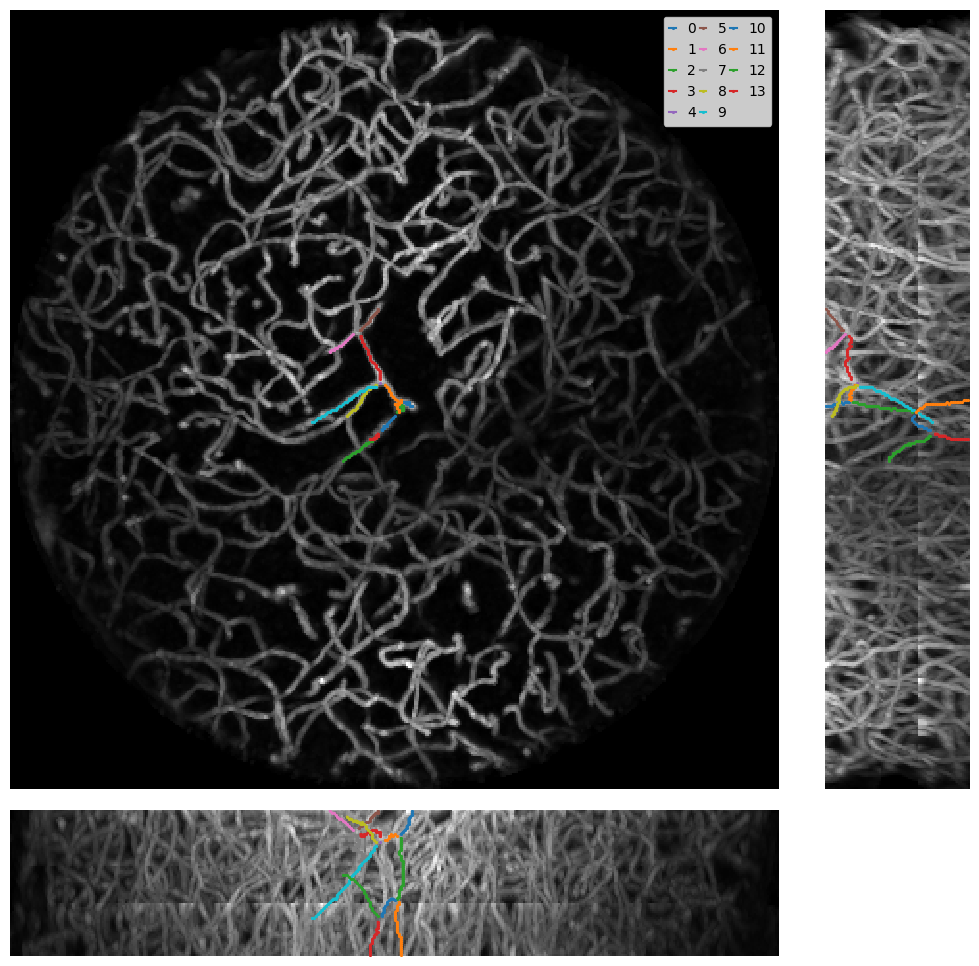

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/long_range_corr/PAE61_dso_3_pos_mips.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/long_range_corr/PAE61_dso_3_pos_mips.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/z100_250um/long_range_corr/PAE61_dso_3_pos_mips.png


In [123]:
# visualize the artery tree(s) with 3 view MIP
f = fg.vis_edges_with_mips(list_idx_to_ael, vsl_mips, figsize=(10, 10), legend_type='idx', show_legend_Q=True)
if save_fig_Q:
    fp = os.path.join(vis_folder, 'long_range_corr', f"PAE{tmp_idx}_dso_{ds_cutoff_order}_pos_mips.png")
    io.print_image_in_several_formats(f, fp)